In [1]:
import os
import cv2
import glob
import json
import math
import torch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

import albumentations as A
from albumentations.pytorch import ToTensorV2

# 최종 output의 image shape & batch size
width      = 512
height     = 512
batch_size = 128

# target 의 해상도 조절 param. width // stride (height // stride) 의 크기로 최종 output이 생성됩니다.
stride     = 4
# target 의 각 점의 넓이 결정
sigma      = 1
# target 의 숫자 (관절 17개)
num_points = 17
# validation ratio
test_size  = 0.2

In [2]:
# 학습을 위한 데이터 파일을 담고 있는 data frame 생성
# image, annotation 폴더의 path를 넣어주시면 됩니다. 
# num_joints 는 17로 고정입니다.
def generate_dataframe(path_data, path_label, num_points=17):
    annots = sorted(glob.glob(os.path.join(path_label, "*.json")))
    target = []

    for fname in tqdm(annots):
        with open(fname, "r") as f:
            data = json.load(f)

        width, height = data['label_info']['image']['width'], data['label_info']['image']['height']
        keypoints = data['label_info']['annotations'][0]['keypoints']
        x, y = [], []
        
        # 이미지 사이즈 오류 나는 경우를 대비해서
        for i in range(num_points):
            x_ = keypoints[i * 3]
            y_ = keypoints[i * 3 + 1]
            
            if x_ >= width:
                x_ -= 1
            if y_ >= height:
                y_ -= 1
            
            x.append(x_)
            y.append(y_)

        keypoints_ = list(zip(x, y))
        target.append(keypoints_)
    
    df = pd.DataFrame({"image": sorted(glob.glob(os.path.join(path_data, "*.jpg"))), "target": target, "target_file": annots})
    
    return df

path_data = './data/images'
path_labels = './data/annotations'

df = generate_dataframe(path_data, path_labels)

train_df, valid_df = train_test_split(df, test_size=test_size)
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)

train_df.head()

  0%|          | 0/9000 [00:00<?, ?it/s]

,image,target,target_file
0,./data/images/livestock_cow_keypoints_004351.jpg,"[(38, 13), (66, 27), (116, 23), (134, 130), (1...",./data/annotations/livestock_cow_keypoints_004...
1,./data/images/livestock_cow_keypoints_005003.jpg,"[(86, 76), (85, 60), (65, 27), (77, 91), (72, ...",./data/annotations/livestock_cow_keypoints_005...
2,./data/images/livestock_cow_keypoints_000453.jpg,"[(72, 11), (66, 11), (49, 5), (55, 35), (55, 4...",./data/annotations/livestock_cow_keypoints_000...
3,./data/images/livestock_cow_keypoints_005228.jpg,"[(123, 63), (116, 71), (100, 5), (11, 134), (1...",./data/annotations/livestock_cow_keypoints_005...
4,./data/images/livestock_cow_keypoints_003043.jpg,"[(36, 27), (81, 37), (107, 36), (92, 99), (91,...",./data/annotations/livestock_cow_keypoints_003...


In [3]:
# Albumentation 을 이용한 augmentation
train_transforms = A.Compose([
    A.augmentations.Resize(width=width, height=height, p=1.0),
    A.augmentations.HorizontalFlip(p=0.5),
#     A.augmentations.ShiftScaleRotate(p=0.5, shift_limit=0.05, scale_limit=0.1, rotate_limit=45),
#     A.HueSaturationValue(p=0.5),
#     A.RandomBrightness(p=0.5),
#     A.GaussNoise(p=0.3),
#     A.GaussianBlur(p=0.3),
#     A.ImageCompression(p=0.3),
    A.augmentations.Normalize(p=1.0),
    ToTensorV2(),
], keypoint_params=A.KeypointParams(format='xy'))

valid_transforms = A.Compose([
    A.augmentations.Resize(width=width, height=height, p=1.0),
    A.augmentations.Normalize(p=1.0),
    ToTensorV2(),
], keypoint_params=A.KeypointParams(format='xy'))


In [4]:
class CustomDataset(Dataset):
    def __init__(self, df, transform, width, height, stride, sigma, num_points=17):
        super().__init__()
        self.df = df
        
        self.transform = transform
        self.num_points = num_points
        
        self.stride = stride
        self.sigma = sigma
    
    
    def __getitem__(self, idx):
        image = cv2.cvtColor(cv2.imread(df.loc[idx, "image"], cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
        keypoints = df.loc[idx, "target"]
        
        transformed = self.transform(image=image, keypoints=keypoints)
        transformed_image = transformed['image']
        transformed_keypoints = transformed['keypoints']
        
        keypoint_maps = self.__generate_heatmap(transformed_keypoints)
        
        return transformed_image, keypoint_maps
        
    
    def __len__(self):
        return self.df.shape[0]
    
    
    def __generate_heatmap(self, points):
        keypoint_maps = np.zeros((self.num_points + 1, width // self.stride, height // self.stride), np.float32)
        
        for index, point in enumerate(points):
            self.__add_gaussian(keypoint_maps[index], point[0], point[1], self.stride, self.sigma)
        
        keypoint_maps[-1] = 1 - keypoint_maps.max(axis=0)
        
        return keypoint_maps
    
    
    def __add_gaussian(self, keypoint_map, x, y, stride, sigma):
        n_sigma = 4
        top_left = [int(x - n_sigma * sigma), int(y - n_sigma * sigma)]
        top_left[0] = max(top_left[0], 0)
        top_left[1] = max(top_left[1], 0)

        bottom_right = [int(x + n_sigma * sigma), int(y + n_sigma * sigma)]
        height, width = keypoint_map.shape
        bottom_right[0] = min(bottom_right[0], width * stride)
        bottom_right[1] = min(bottom_right[1], height * stride)

        shift = stride / 2 - 0.5
        for map_y in range(top_left[1] // stride, bottom_right[1] // stride):
            for map_x in range(top_left[0] // stride, bottom_right[0] // stride):
                d2 = (map_x * stride + shift - x) * (map_x * stride + shift - x) + \
                    (map_y * stride + shift - y) * (map_y * stride + shift - y)
                exponent = d2 / 2 / sigma / sigma
                if exponent > 4.6052:  # threshold, ln(100), ~0.01
                    continue
                keypoint_map[map_y, map_x] += math.exp(-exponent)
                if keypoint_map[map_y, map_x] > 1:
                    keypoint_map[map_y, map_x] = 1

In [5]:
# target 은 총 18개의 채널으로 나옵니다. 이때 각 차원은 하나의 joint에 해당합니다.
# 마지막 18번째 채널은 전체 joint를 담고 있습니다. (학습에서는 사용하지 않습니다)
# X shape: batch_size * 3 * width * height
# y shape: batch_size * (num_points + 1) * (width // stride) * (height // stride)
# 따라서 학습 시킬 때, y의 0 ~ 17 채널까지의 결과를 flatten 시킨 후, 모델이 에측한 값의 flatten과 각각 비교하면 됩니다.  

train_dataset = CustomDataset(train_df, train_transforms, width=width, height=height, stride=stride, sigma=sigma, num_points=num_points)
# train_iterator = DataLoader(train_dataset, batch_size=batch_size, num_workers=8, shuffle=True)
train_iterator = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = CustomDataset(valid_df, valid_transforms, width=width, height=height, stride=stride, sigma=sigma, num_points=num_points)
# valid_iterator = DataLoader(valid_dataset, batch_size=batch_size, num_workers=8, shuffle=False)
valid_iterator = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)


/Users/jonghyun/miniforge3/envs/pytorch/lib/python3.8/site-packages/albumentations/augmentations/functional.py:138: RuntimeWarning: divide by zero encountered in reciprocal
  denominator = np.reciprocal(std, dtype=np.float32)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


X shape: torch.Size([128, 3, 512, 512]) & y shape: torch.Size([128, 18, 128, 128])


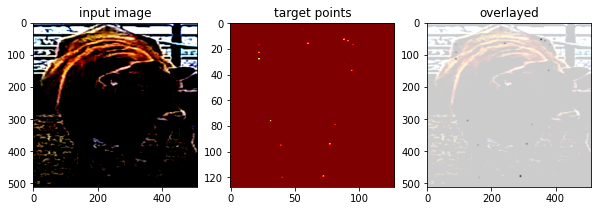

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


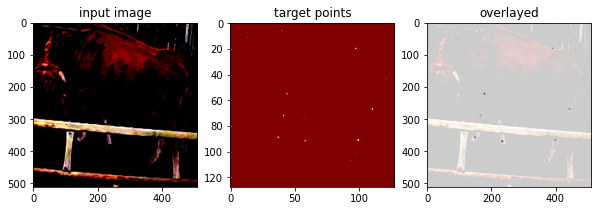

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


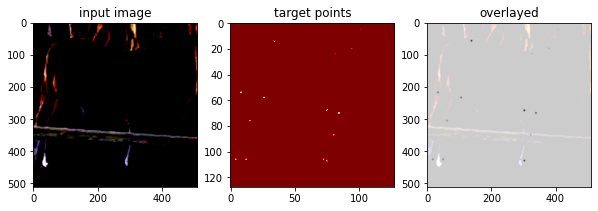

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


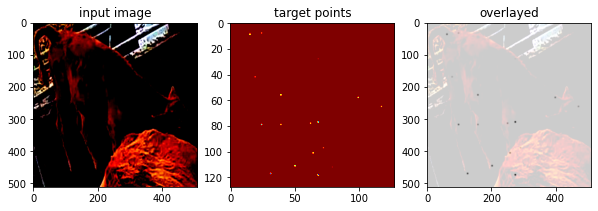

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


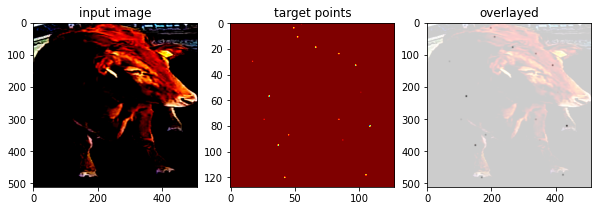

In [6]:
from skimage.transform import resize

for X, y in train_iterator:
    print(f"X shape: {X.shape} & y shape: {y.shape}")
    
    for index in np.arange(5):
        image   = torch.moveaxis(X[index, :, :, :], 0, -1)
        heatmap = torch.moveaxis(y[index, :, :, :], 0, -1)
        
        plt.figure(figsize=(10, 10))
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title('input image')
        
        plt.subplot(1, 3, 2)
        plt.imshow(heatmap[:, :, -1], cmap='jet')
        plt.title('target points')

        plt.subplot(1, 3, 3)
        plt.imshow(resize(heatmap[:, :, -1], (width, height)), cmap='gray')
        plt.imshow(image, alpha=0.2)
        plt.title('overlayed')
        
        plt.show()
        
    break